In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
from numba import jit, njit, prange
from quantecon.util import tic, toc

In [2]:
@njit
def u(c):
    return np.log(c)

In [3]:
class AiyagariProb:
    
    def __init__(self,
                 r=0.01,                      # interest rate
                 w=1.0,                       # wages
                 cbeta=0.96,                  # discount factor
                 a_min=-5,
                 P=[[0.9, 0.1], [0.1, 0.9]],  # Markov chain
                 z_vals=[0.1, 1.0],           # exogenous states
                 a_max=18,
                 a_size=200
                 ):
        
        #making all options class objects
        self.r, self.w, self.cbeta = r, w, cbeta 
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size
        self.P, self.z_vals = np.asarray(P), np.asarray(z_vals)
        self.z_size = len(z_vals)
        
        self.a_grid = np.linspace(a_min, a_max, a_size)
    
    def pack_params(self):
        return self.r, self.w, self.cbeta, self.a_min, self.a_max, self.a_size, self.P, self.z_vals, self.a_grid
        
    def bellman_operator(self):
        
        r, w, cbeta, a_min, a_max, a_size, P, z_vals, a_grid = self.pack_params()
        
        @njit
        def T(v, v_out, pol):
            n, m = v.shape

            for j in prange(m):
                z = z_vals[j]

                for i in range(n):
                    x = a_grid[i]
                    # Cash in hand at start of period
                    y = (1.0 + r) * x + w * z
                    max_so_far = - np.inf
                    # Find largest x_grid index s.t. x' <= y
                    idx = np.searchsorted(a_grid, y)
                    # Step through x' with 0 <= x' <= y, find max
                    for k in range(idx):
                        x_next = a_grid[k]
                        val = u(y - x_next) + cbeta * np.sum(v[k, :] * P[j, :])
                        if val > max_so_far:
                            max_so_far = val
                            a_star = k

                    pol[i, j] = a_star
                    v_out[i, j] = max_so_far

        return T

In [4]:
@njit
def vfi(T, v_init, tol=1e-4, max_iter=1000):

    # Set initial condition, set up storage
    v_in = v_init
    v_out = np.empty_like(v_in)
    pol = np.empty_like(v_in, dtype=np.int_)
    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        T(v_in, v_out, pol)
        error = np.max(np.abs(v_in - v_out))
        i += 1
        v_in[:] = v_out
    return v_out, pol

In [5]:
mod = AiyagariProb()
T = mod.bellman_operator()
v_init = np.ones((mod.a_size, mod.z_size))

In [6]:
tic()
v_star, pol = vfi(T, v_init)
toc()

TOC: Elapsed: 0:00:2.12


2.1291255950927734

In [7]:
@njit(parallel=True)
def simulate_stationary_assets(pol, 
                               P, 
                               a_grid, 
                               i_init=10, 
                               j_init=0, 
                               num_households=100_000,
                               ts_length=1000):
    asset_vals = np.empty(num_households)
    for m in prange(num_households):
        i = i_init
        j = j_init

        for t in range(ts_length-1):
            i = pol[i, j]
            j = qe.random.draw(np.cumsum(P[j, :]))
            
        asset_vals[m] = a_grid[i]
        
    return asset_vals

TOC: Elapsed: 0:00:12.38


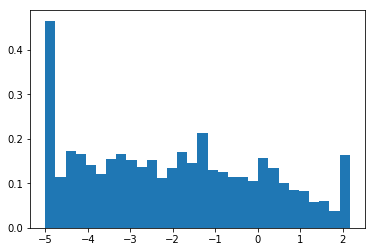

In [8]:
tic()
asset_vals = simulate_stationary_assets(pol,mod.P, mod.a_grid)
toc()
fig, ax = plt.subplots()
ax.hist(asset_vals, bins = 30, density=True)
plt.show()

In [66]:
A = 1.0
N = 1.0
calpha = 0.33
cbeta = 0.96
cdelta = 0.05


def r_to_w(r):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    
    return (A * (1 - calpha) * (A * calpha / (r + cdelta))**(calpha / (1 - calpha)))

def rd(K):
    """
    Inverse demand curve for capital.  The interest rate associated with a
    given demand for capital K.
    """
    return (A * calpha * (N / K)**(1 - calpha) - cdelta)

def prices_to_capital_stock():
    """
    Map prices to the induced level of capital stock.
    
    Parameters:
    ----------
    
    am : Household
        An instance of an aiyagari_household.Household 
    r : float
        The interest rate
    """
    asset_vals = simulate_stationary_assets(pol,mod.P, mod.a_grid)
    return np.mean(asset_vals)


In [136]:
r, k = get_eq()

In [107]:
#getting equilibrium

r_range = np.linspace(0.02, 0.04, 30)
tol = 1e-3
error = tol + 1
n = 0
n_iter = 100

while error > tol and n < n_iter:

    r_i = r_range[n]
    # Figure out firm problem

    w_i = r_to_w(r_i)

    # Solve agents problems
    mod = AiyagariProb(r = r_i, w = w_i)
    T = mod.bellman_operator()
    v_init = np.ones((mod.a_size, mod.z_size))
    v_star, pol = vfi(T, v_init)

    k_s = prices_to_capital_stock()

    # get back how much the firm is willing to pay for that K_s
    r_star = rd(k_s)

    # Error
    error = np.absolute(r_star - r_i)

    n = n + 1
    
    print(f'Iter: {n} ; Error: {error}; interest rate: {r_i}')

print(f'Equilibrium Interest Rate: {r_i} \nEquilibrium Capital Stock: {k_s}')

Iter: 1 ; Error: 0.042182406198914016; interest rate: 0.02
Iter: 2 ; Error: 0.040328377282053005; interest rate: 0.020689655172413793
Iter: 3 ; Error: 0.03738892113103212; interest rate: 0.021379310344827585
Iter: 4 ; Error: 0.03555748410213659; interest rate: 0.02206896551724138
Iter: 5 ; Error: 0.03274195046880719; interest rate: 0.022758620689655173
Iter: 6 ; Error: 0.030102389993885075; interest rate: 0.023448275862068966
Iter: 7 ; Error: 0.028030998439461878; interest rate: 0.02413793103448276
Iter: 8 ; Error: 0.025272277111967584; interest rate: 0.024827586206896554
Iter: 9 ; Error: 0.02257943091596194; interest rate: 0.025517241379310347
Iter: 10 ; Error: 0.019988859194551893; interest rate: 0.02620689655172414
Iter: 11 ; Error: 0.017597155389363853; interest rate: 0.02689655172413793
Iter: 12 ; Error: 0.015066455280030727; interest rate: 0.027586206896551724
Iter: 13 ; Error: 0.012495614334281806; interest rate: 0.02827586206896552
Iter: 14 ; Error: 0.010144634158773928; intere

# Experimental Stuff